In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import itertools
import warnings

Data Collection

In [51]:
df = pd.read_excel('Data/Data.xlsx')

In [52]:
df

,Date,Private Investment Index,Government Debt,State Enterprises Debt,Special Financial Institutions Guaranteed Debt,Government Agency Debt,Consumer Confident Index
0,2013-01-31,121.9,3531418.63,1066503.28,202267.50,6953.53,33.1
1,2013-02-28,118.9,3555634.61,1072414.05,203271.11,8053.53,32.4
2,2013-03-31,131.8,3563398.53,1069302.32,204270.91,5561.91,37.9
3,2013-04-30,117.2,3589728.39,1060180.28,213508.27,3383.37,42.2
4,2013-05-31,126.5,3609170.92,1065687.08,214507.48,813.37,20.1
...,...,...,...,...,...,...,...
127,2023-08-31,132.7,9676757.05,1075590.65,501363.31,61124.84,53.4
128,2023-09-30,130.1,9779786.75,1076922.26,501461.57,61416.92,55.7
129,2023-10-31,143.9,9779797.23,1079735.23,493652.23,61624.71,55.8
130,2023-11-30,156.2,9780061.01,1076508.49,437874.37,71757.68,55.0


In [53]:
df.describe()

,Date,Private Investment Index,Government Debt,State Enterprises Debt,Special Financial Institutions Guaranteed Debt,Government Agency Debt,Consumer Confident Index
count,132,132.000000,1.320000e+02,1.320000e+02,132.000000,132.000000,132.000000
mean,2018-07-15 23:49:05.454545408,131.334848,5.893004e+06,9.692037e+05,393561.913485,14202.471591,41.593939
min,2013-01-31 00:00:00,110.500000,3.531419e+06,7.532737e+05,202267.500000,813.370000,20.100000
25%,2015-10-23 06:00:00,122.525000,4.231277e+06,8.908156e+05,285357.460000,7129.635000,37.075000
50%,2018-07-15 12:00:00,129.100000,5.239306e+06,9.720871e+05,375769.345000,8787.425000,40.500000
75%,2021-04-07 12:00:00,140.400000,7.418175e+06,1.065321e+06,516717.242500,16754.975000,45.725000
max,2023-12-31 00:00:00,158.700000,9.780061e+06,1.112974e+06,625508.190000,81746.760000,56.600000
std,NaN,11.451031,1.997688e+06,1.011994e+05,124110.701967,14859.411034,6.699912


Data Cleansing

Set datetime index

In [54]:
df.index = df['Date'].values
df = df.drop(columns=['Date'])

In [55]:
df

,Private Investment Index,Government Debt,State Enterprises Debt,Special Financial Institutions Guaranteed Debt,Government Agency Debt,Consumer Confident Index
2013-01-31,121.9,3531418.63,1066503.28,202267.50,6953.53,33.1
2013-02-28,118.9,3555634.61,1072414.05,203271.11,8053.53,32.4
2013-03-31,131.8,3563398.53,1069302.32,204270.91,5561.91,37.9
2013-04-30,117.2,3589728.39,1060180.28,213508.27,3383.37,42.2
2013-05-31,126.5,3609170.92,1065687.08,214507.48,813.37,20.1
...,...,...,...,...,...,...
2023-08-31,132.7,9676757.05,1075590.65,501363.31,61124.84,53.4
2023-09-30,130.1,9779786.75,1076922.26,501461.57,61416.92,55.7
2023-10-31,143.9,9779797.23,1079735.23,493652.23,61624.71,55.8
2023-11-30,156.2,9780061.01,1076508.49,437874.37,71757.68,55.0


Define target

In [56]:
target = 'Private Investment Index'

<Axes: >

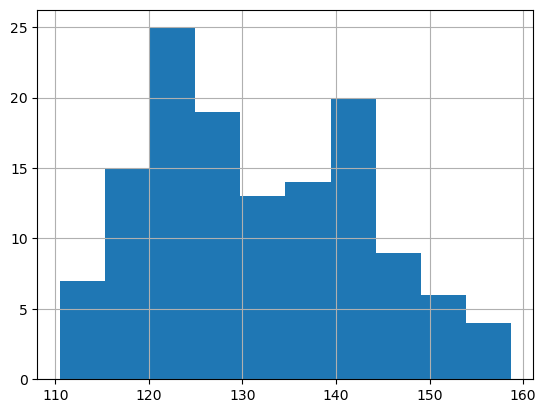

In [57]:
df[target].hist()

Data type

In [58]:
df.dtypes

Private Investment Index                          float64
Government Debt                                   float64
State Enterprises Debt                            float64
Special Financial Institutions Guaranteed Debt    float64
Government Agency Debt                            float64
Consumer Confident Index                          float64
dtype: object

Missing Value

In [59]:
df = df.dropna(subset=[target])

In [60]:

df.isnull().sum()

Private Investment Index                          0
Government Debt                                   0
State Enterprises Debt                            0
Special Financial Institutions Guaranteed Debt    0
Government Agency Debt                            0
Consumer Confident Index                          0
dtype: int64

In [61]:
df

,Private Investment Index,Government Debt,State Enterprises Debt,Special Financial Institutions Guaranteed Debt,Government Agency Debt,Consumer Confident Index
2013-01-31,121.9,3531418.63,1066503.28,202267.50,6953.53,33.1
2013-02-28,118.9,3555634.61,1072414.05,203271.11,8053.53,32.4
2013-03-31,131.8,3563398.53,1069302.32,204270.91,5561.91,37.9
2013-04-30,117.2,3589728.39,1060180.28,213508.27,3383.37,42.2
2013-05-31,126.5,3609170.92,1065687.08,214507.48,813.37,20.1
...,...,...,...,...,...,...
2023-08-31,132.7,9676757.05,1075590.65,501363.31,61124.84,53.4
2023-09-30,130.1,9779786.75,1076922.26,501461.57,61416.92,55.7
2023-10-31,143.9,9779797.23,1079735.23,493652.23,61624.71,55.8
2023-11-30,156.2,9780061.01,1076508.49,437874.37,71757.68,55.0


Data Analysis

Plot the scatter plot between Consumer Confident Index and Pivate Investment Index with a trend line

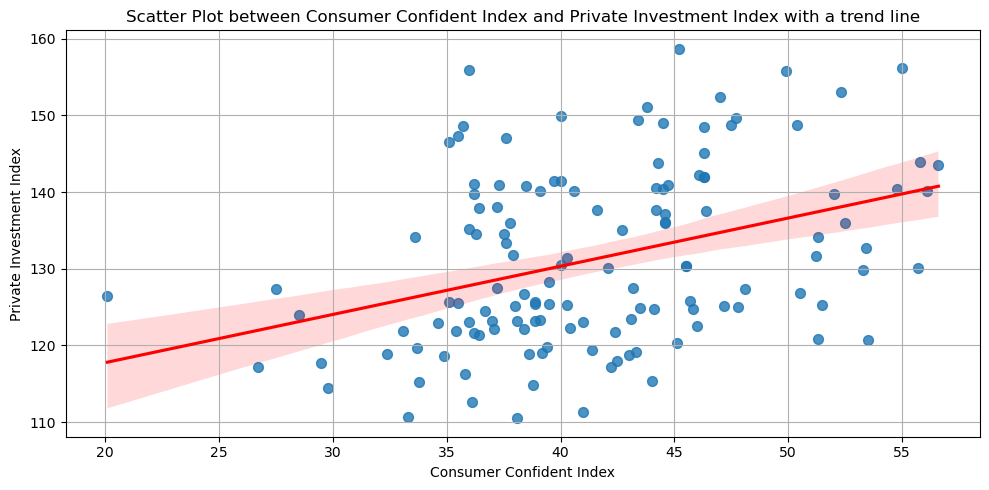

In [62]:
plt.figure(figsize=(10, 5))
sns.regplot(x='Consumer Confident Index', y='Private Investment Index', data=df, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Scatter Plot between Consumer Confident Index and Private Investment Index with a trend line')
plt.xlabel('Consumer Confident Index')
plt.ylabel('Private Investment Index')
plt.grid(True)
plt.tight_layout()
plt.show()

Plot the histogram of Pivate Investment Index

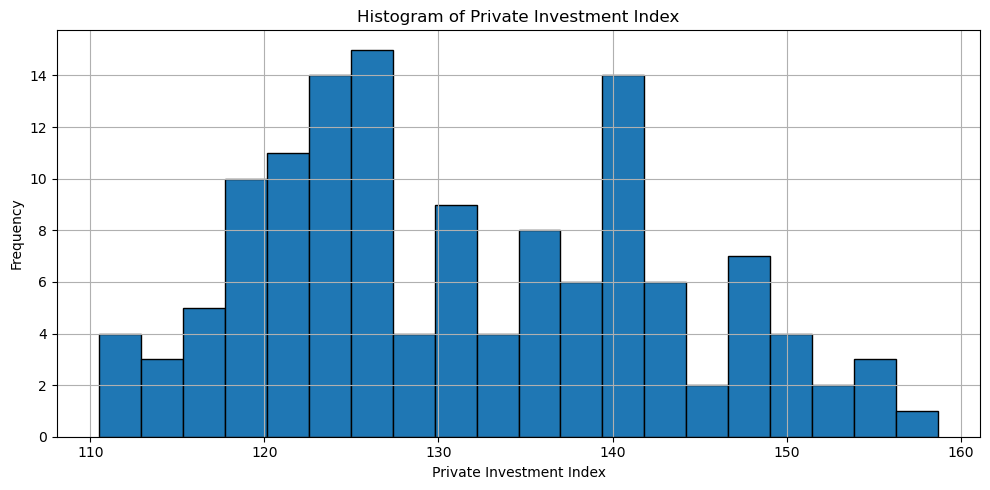

In [63]:
plt.figure(figsize=(10, 5))
plt.hist(df['Private Investment Index'], bins=20, edgecolor='black')
plt.title('Histogram of Private Investment Index')
plt.xlabel('Private Investment Index')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

Time Series analysis

Observation

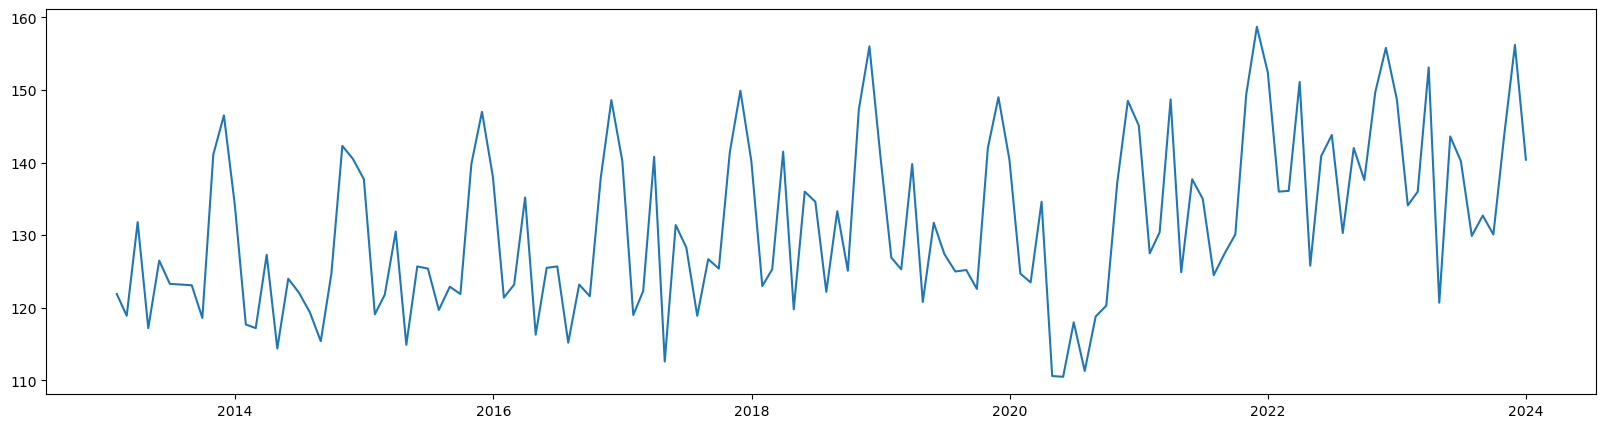

In [64]:
plt.figure(figsize=(20, 5))
plt.plot(df[target])
plt.show()

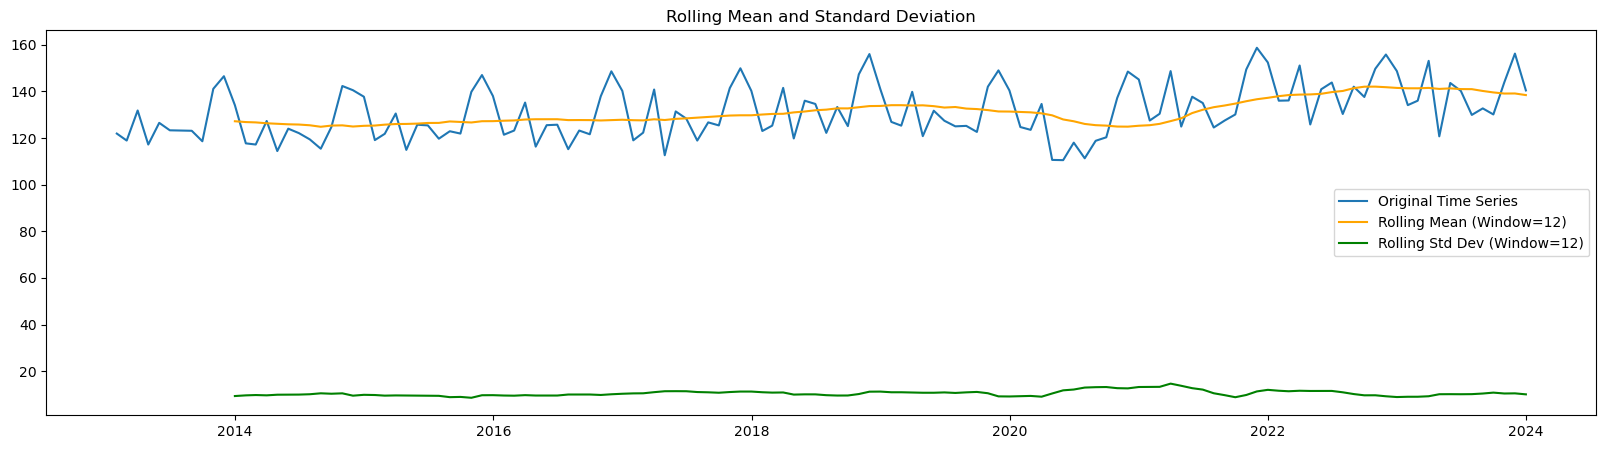

In [65]:
window_size = 12

rolling_mean = df[target].rolling(window=window_size).mean()
rolling_std = df[target].rolling(window=window_size).std()

plt.figure(figsize=(20, 5))
plt.plot(df[target], label='Original Time Series')
plt.plot(rolling_mean, label='Rolling Mean (Window=12)', color='orange')
plt.plot(rolling_std, label='Rolling Std Dev (Window=12)', color='green')
plt.title('Rolling Mean and Standard Deviation')
plt.legend()
plt.show()

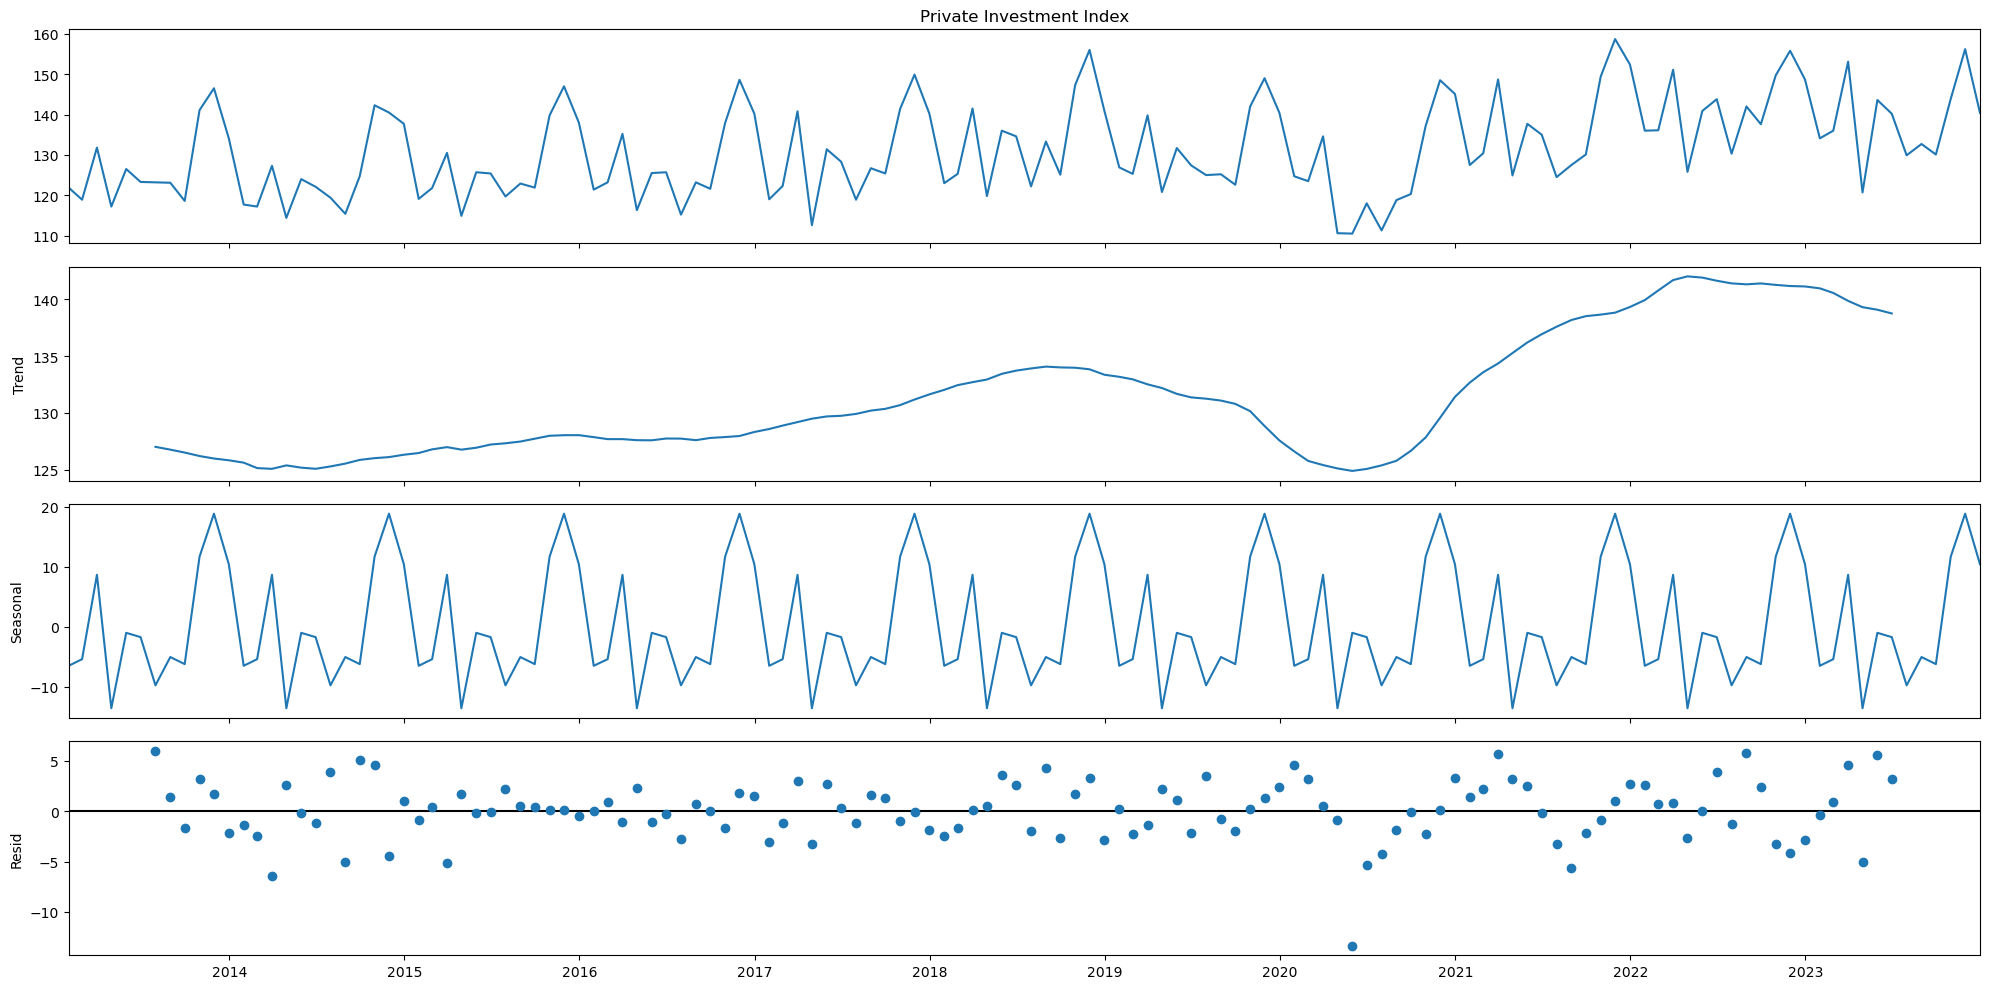

In [66]:
decomposition = seasonal_decompose(df[target], model='additive', period=12)
plt.rcParams.update({'figure.figsize': (20, 10)})
decomposition.plot()
plt.show()

In [67]:
adf_test_result = adfuller(df[target])

In [68]:
adf_test_result

(-1.8488841249500145,
 0.3564760985947102,
 13,
 118,
 {'1%': -3.4870216863700767,
  '5%': -2.8863625166643136,
  '10%': -2.580009026141913},
 705.0381494066828)

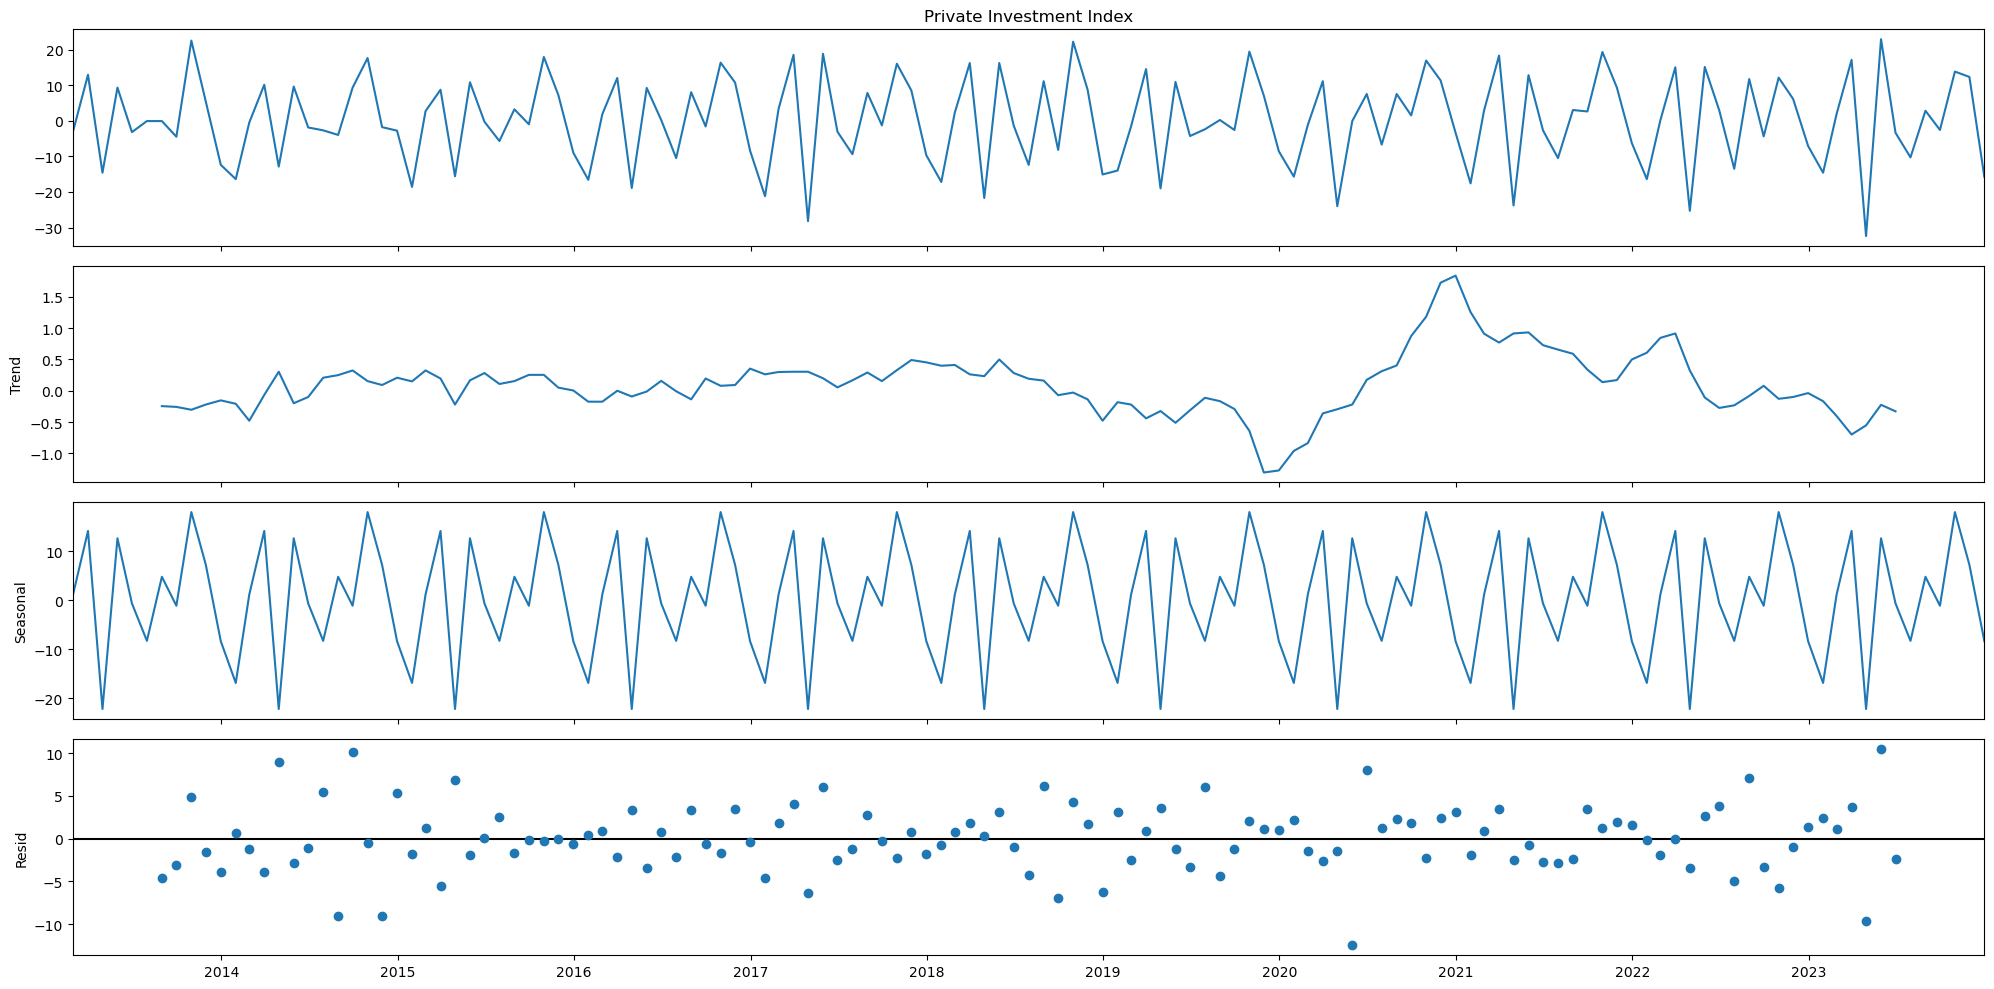

In [69]:
plt.rcParams.update({'figure.figsize': (20, 10)})
diff_series = df[target].diff().dropna()
decomposition = seasonal_decompose(diff_series, model='additive', period=12)
decomposition.plot()
plt.show()

In [70]:
adf_test_result = adfuller(diff_series)

In [71]:
adf_test_result

(-2.8628793492615445,
 0.049838041613175406,
 12,
 118,
 {'1%': -3.4870216863700767,
  '5%': -2.8863625166643136,
  '10%': -2.580009026141913},
 702.0072450582419)

Time series parameters

Autocorrelation

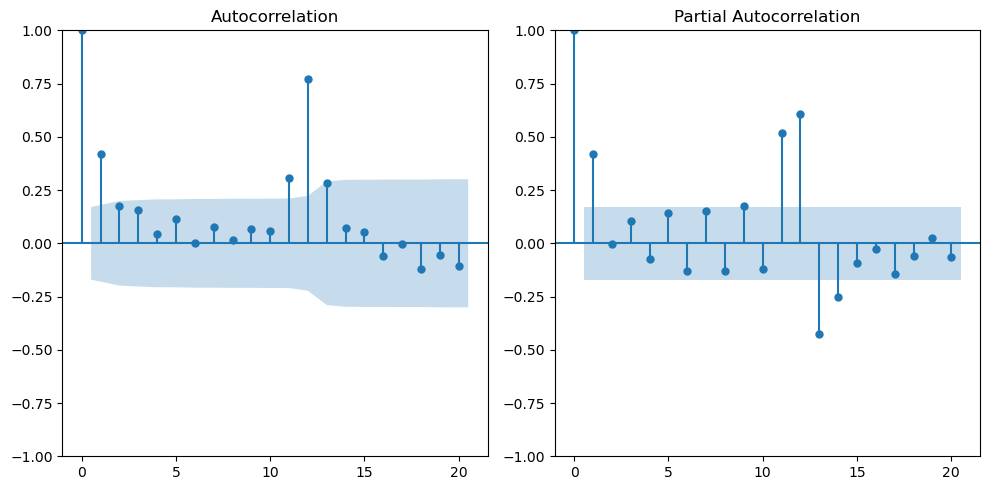

In [72]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_acf(df[target], lags=20, ax=plt.gca())
plt.subplot(122)
plot_pacf(df[target], lags=20, ax=plt.gca())
plt.tight_layout()
plt.show()

AIC

In [73]:
p = q = range(0, 4)
d = [1]
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_pdq = None
warnings.filterwarnings('ignore')

for param in pdq:
    try:
        model = ARIMA(df[target], order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
    except:
        continue

In [74]:
best_pdq

(3, 1, 3)

Feature selection

Granger test

In [75]:
raw_features = [x for x in df.columns if x != target]

In [76]:
max_lag = 5
granger_results = {}
for feature in raw_features:
    granger_result = grangercausalitytests(df[[target, feature]], maxlag=max_lag, verbose=False)
    granger_results[feature] = {lag: result[0]['ssr_ftest'] for lag, result in granger_result.items()}

In [77]:
for feature in raw_features:
    print(feature)
    print(pd.DataFrame(granger_results[feature], index=['F-statistic', 'p-values', 'degree-of-freedom', 'lag']))

Government Debt
                            1           2           3           4          5
F-statistic         14.255661    7.868479    4.776826    4.174664    3.34864
p-values             0.000243    0.000604    0.003496    0.003365    0.00732
degree-of-freedom  128.000000  125.000000  122.000000  119.000000  116.00000
lag                  1.000000    2.000000    3.000000    4.000000    5.00000
State Enterprises Debt
                            1           2           3           4           5
F-statistic          0.636602    1.407110    3.067709    3.636501    3.859962
p-values             0.426422    0.248701    0.030532    0.007833    0.002848
degree-of-freedom  128.000000  125.000000  122.000000  119.000000  116.000000
lag                  1.000000    2.000000    3.000000    4.000000    5.000000
Special Financial Institutions Guaranteed Debt
                            1           2           3           4           5
F-statistic          9.083189    4.947734    3.110206    4.51

Transform lag

In [78]:
df['Government Agency Debt'] = df['Government Agency Debt'].shift(4)
df['Consumer Confident Index'] = df['Consumer Confident Index'].shift(4)
df = df.drop(columns=['Special Financial Institutions Guaranteed Debt'])
df = df.drop(columns=['State Enterprises Debt'])
df = df.drop(columns=['Government Debt'])
df = df.dropna() 

Multicollinearility

In [79]:
features = [x for x in df.columns if x != target]
X = df[features]
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

                    Feature       VIF
0    Government Agency Debt  2.536269
1  Consumer Confident Index  2.536269


Split dataset

In [80]:
train_ratio = 0.7
train_size = int(train_ratio * len(df))
split_date = df.index[train_size]

In [81]:
train_df = df[df.index <= split_date]
test_df = df[df.index > split_date]

In [82]:
train_df.tail()

,Private Investment Index,Government Agency Debt,Consumer Confident Index
2020-06-30,118.0,8611.98,43.1
2020-07-31,111.3,8028.42,37.5
2020-08-31,118.8,8014.50,33.3
2020-09-30,120.3,7936.02,38.1
2020-10-31,137.2,7858.47,42.5


In [83]:
test_df.head()

,Private Investment Index,Government Agency Debt,Consumer Confident Index
2020-11-30,148.5,7715.91,41.0
2020-12-31,145.1,7677.85,43.0
2021-01-31,127.5,7821.47,45.1
2021-02-28,130.4,7777.22,44.6
2021-03-31,148.7,7690.51,46.3


Feature engineering

In [84]:
y_train = train_df[target]
X_train = train_df[features]
y_test = test_df[target]
X_test = test_df[features]

Standardization

In [85]:
scaler = StandardScaler()

In [86]:
train_index = X_train.index
X_train_scale = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_train_scale.index = train_index

In [87]:
X_train_scale.head()

,Government Agency Debt,Consumer Confident Index
2013-05-31,-0.621468,-1.047761
2013-06-30,-0.437710,-1.173421
2013-07-31,-0.853942,-0.186096
2013-08-31,-1.217872,0.585813
2013-09-30,-1.647197,-3.381439


In [88]:
test_index = X_test.index
X_test_scale = pd.DataFrame(scaler.transform(X_test), columns=features)
X_test_scale.index = test_index

Model

In [89]:
model = ARIMA(y_train, exog=X_train, order=best_pdq)
model_fit = model.fit()

In [90]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                   
====================================================================================
Dep. Variable:     Private Investment Index   No. Observations:                   90
Model:                       ARIMA(3, 1, 3)   Log Likelihood                -324.838
Date:                      Wed, 16 Oct 2024   AIC                            667.675
Time:                              13:28:16   BIC                            690.073
Sample:                          05-31-2013   HQIC                           676.703
                               - 10-31-2020                                         
Covariance Type:                        opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Government Agency Debt       0.0003      0.000      0.933      0.351      -0.000       0.001
Consumer Confident Index    -0.0369      0.290     -0.127      0.899      -0.606       0.532
ar.L1                       -1.2564      0.339     -3.710      0.000      -1.920      -0.593
ar.L2                       -0.2180      0.322     -0.676      0.499      -0.850       0.414
ar.L3                        0.2564      0.243      1.056      0.291      -0.220       0.732
ma.L1                        0.7397      7.207      0.103      0.918     -13.385      14.865
ma.L2                       -0.9010     12.527     -0.072      0.943     -25.454      23.652
ma.L3                       -0.8381      6.043     -0.139      0.890     -12.683      11.006
sigma2                     101.8491    732.247      0.139      0.889   -1333.329    1537.027
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 1.23
Prob(Q):                              0.68   Prob(JB):                         0.54
Heteroskedasticity (H):               1.43   Skew:                             0.11
Prob(H) (two-sided):                  0.33   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Evaluate

Long step

In [91]:
y_pred = model_fit.forecast(len(y_test), exog=X_test)

In [92]:
mean_squared_error(y_pred, y_test)

212.54429811504667

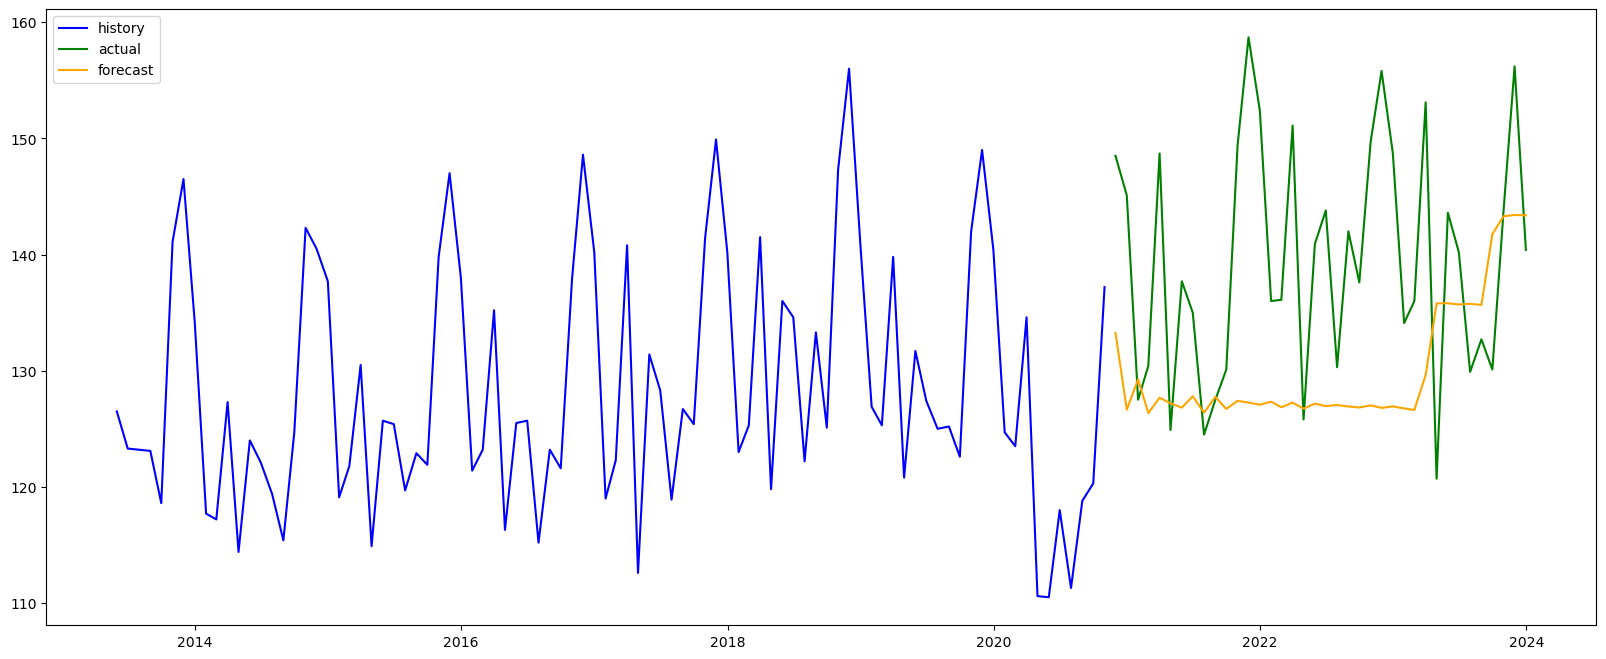

In [93]:
plt.figure(figsize=(20, 8))
plt.plot(y_train.index, y_train, c='blue', label='history')
plt.plot(y_test.index, y_test, c='green', label='actual')
plt.plot(y_test.index, y_pred, c='orange', label='forecast')
plt.legend()
plt.show()

Non Linear Regression

Regressor Trees

Feature Selection

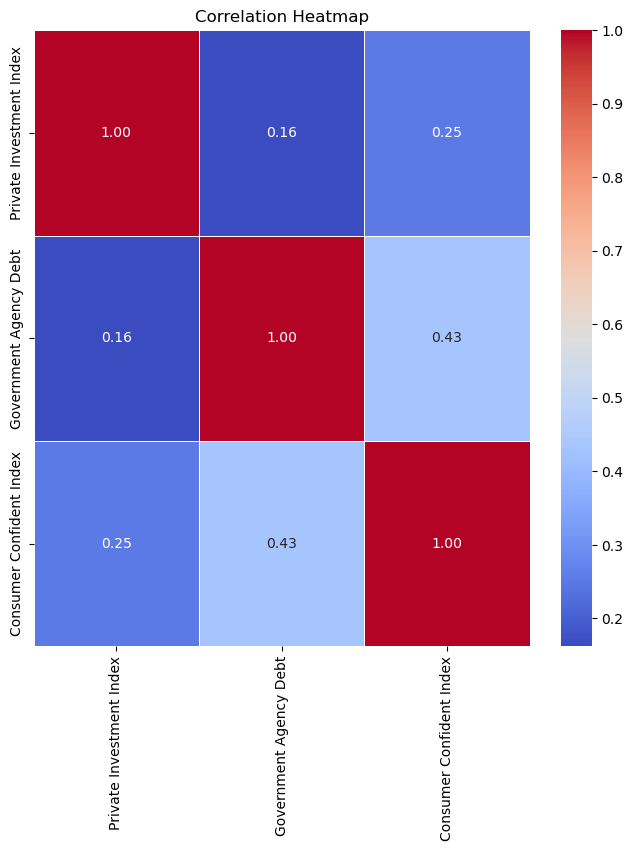

In [94]:
correlation_matrix = df.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Model

In [95]:
def get_feature_importances(model, X):
    """
    Get a feature importance dataFrame from best parameters.
    """
    importances = model.best_estimator_.feature_importances_

    importances_df = pd.DataFrame({
        'features': X.columns,
        'importances': importances
    })

    importances_df = importances_df.sort_values(by='importances', ascending=False)
    importances_df = importances_df.reset_index(drop=True)

    return importances_df

In [96]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

Decision Tree

In [97]:
dt_param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [98]:
dt = DecisionTreeRegressor(random_state=42)
dt_model = GridSearchCV(estimator=dt, param_grid=dt_param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
dt_model.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

In [99]:

get_feature_importances(dt_model, X_train)

,features,importances
0,Government Agency Debt,0.782327
1,Consumer Confident Index,0.217673


Random Forest

In [100]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [101]:
rf = RandomForestRegressor(random_state=42)
rf_model = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=kf, n_jobs=-1)
rf_model.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [102]:
get_feature_importances(rf_model, X_train)

,features,importances
0,Government Agency Debt,0.647312
1,Consumer Confident Index,0.352688


XGBoost

In [103]:
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 0.1, 0]
}

In [104]:
xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_model.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [50, 100, 200],
                         'reg_alpha': [0, 0.1, 1], 'reg_lambda': [1, 0.1, 0]},
             scoring='neg_mean_squared_error')

In [105]:
get_feature_importances(xgb_model, X_train)

,features,importances
0,Government Agency Debt,0.624582
1,Consumer Confident Index,0.375418


Evaluate

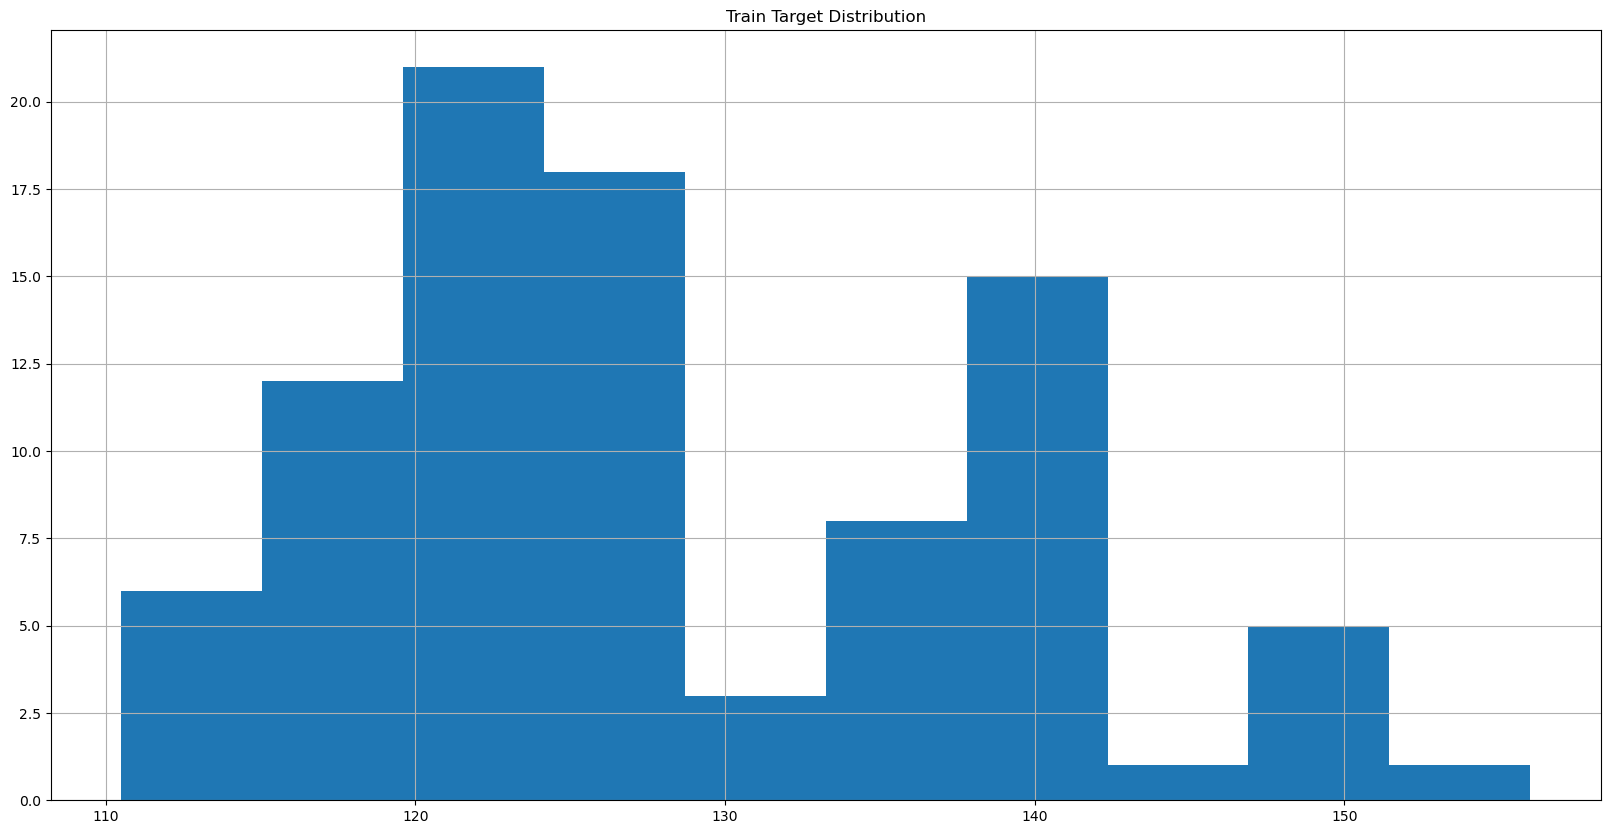

In [106]:
y_train.hist()
plt.title('Train Target Distribution')
plt.show()

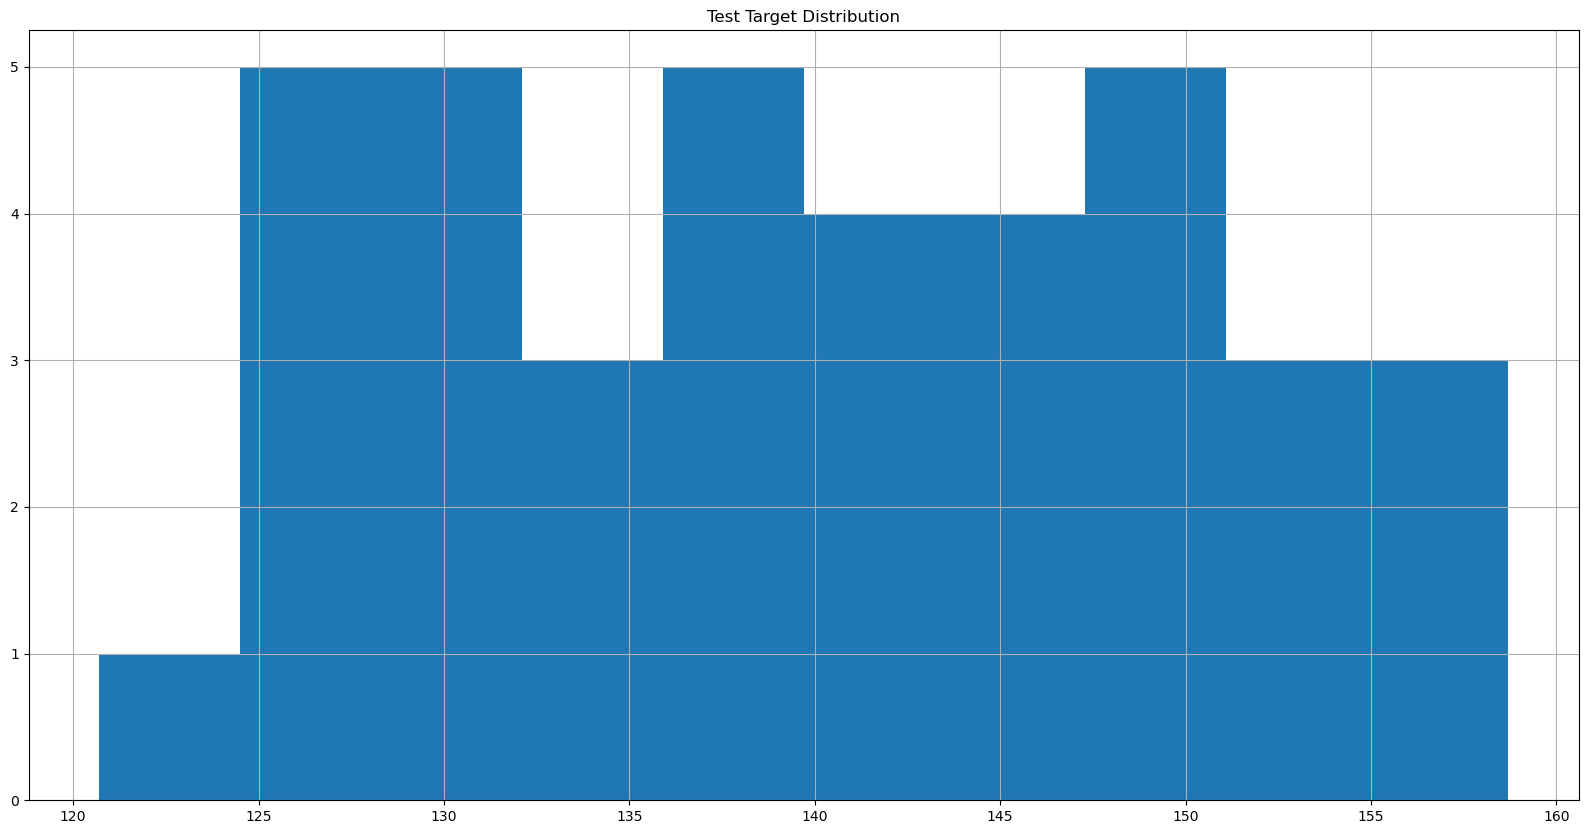

In [107]:
y_test.hist()
plt.title('Test Target Distribution')
plt.show()

Decision Tree

In [108]:
y_pred_train = dt_model.best_estimator_.predict(X_train)
mean_squared_error(y_pred_train, y_train)

70.62023665870171

In [109]:
y_pred = dt_model.best_estimator_.predict(X_test)
mean_squared_error(y_pred, y_test)

295.78402474612466

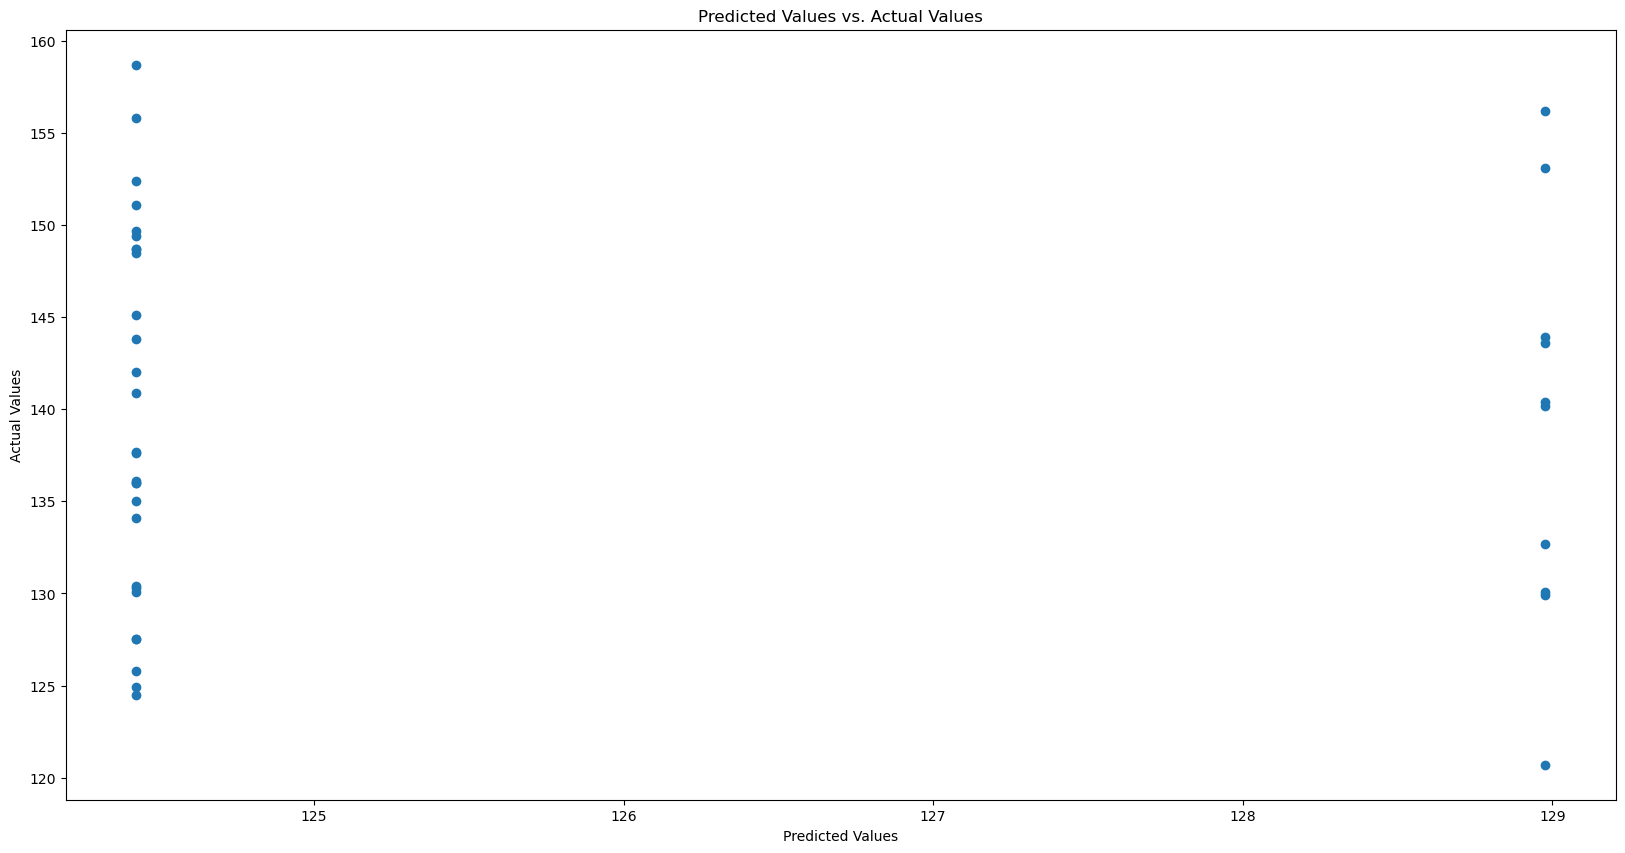

In [110]:
plt.scatter(y_pred, y_test)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted Values vs. Actual Values')
plt.show()

Random Forest

In [111]:
y_pred = rf_model.best_estimator_.predict(X_train)
mean_squared_error(y_pred, y_train)

38.77070415902492

In [112]:
y_pred = rf_model.best_estimator_.predict(X_test)
mean_squared_error(y_pred, y_test)

257.8572500350275

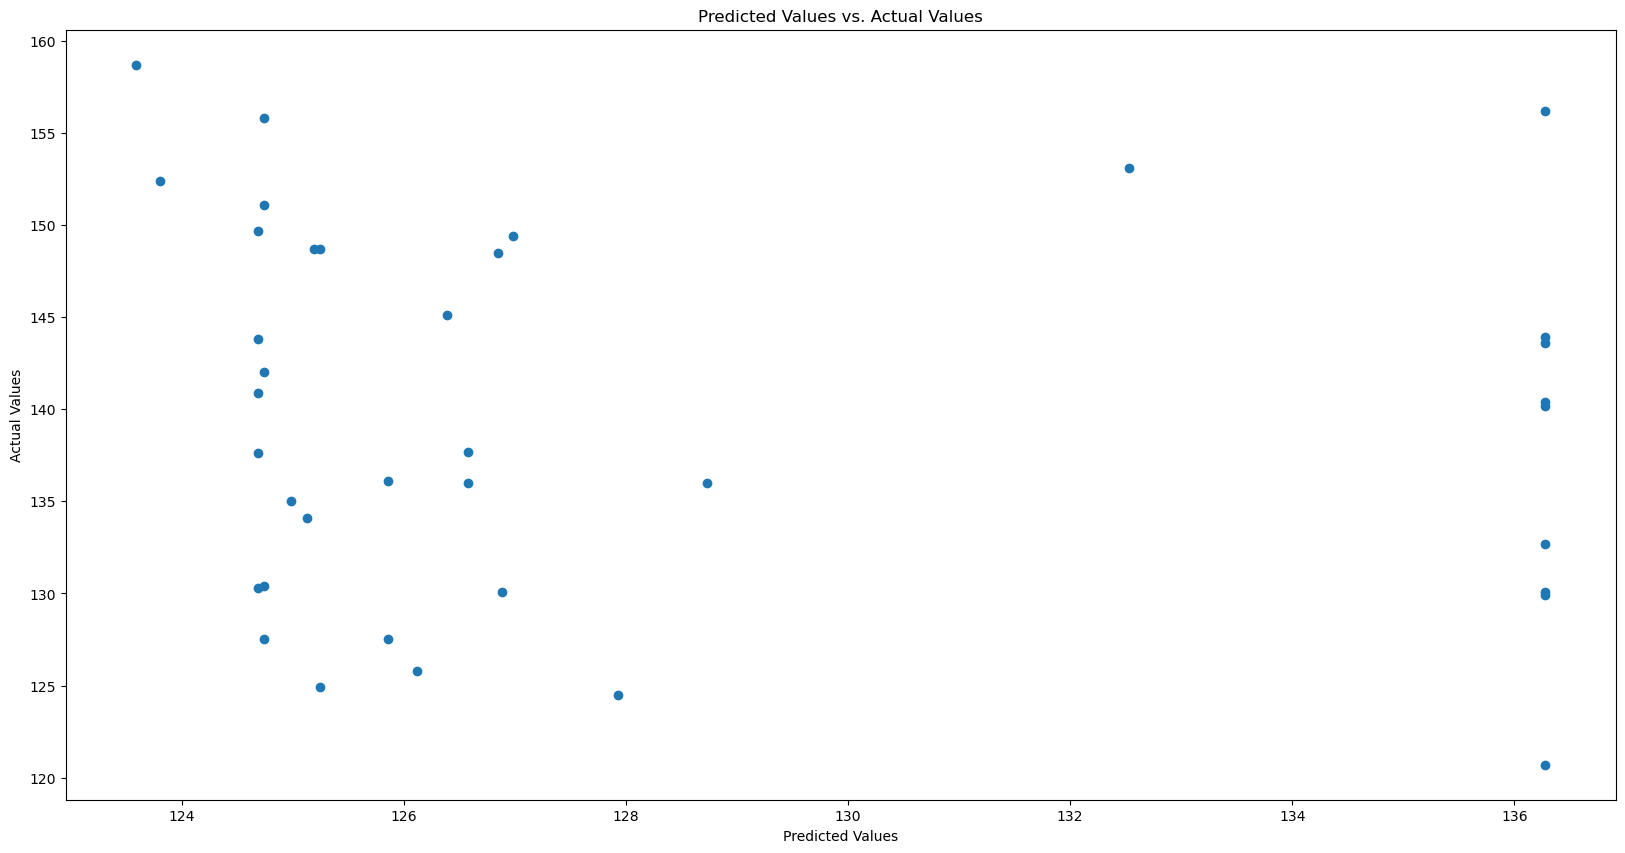

In [113]:
plt.scatter(y_pred, y_test)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted Values vs. Actual Values')
plt.show()

XGBoost

In [114]:
y_pred = xgb_model.best_estimator_.predict(X_train)
mean_squared_error(y_pred, y_train)

72.98893800763278

In [115]:
y_pred = xgb_model.best_estimator_.predict(X_test)
mean_squared_error(y_pred, y_test)

221.63904320509678

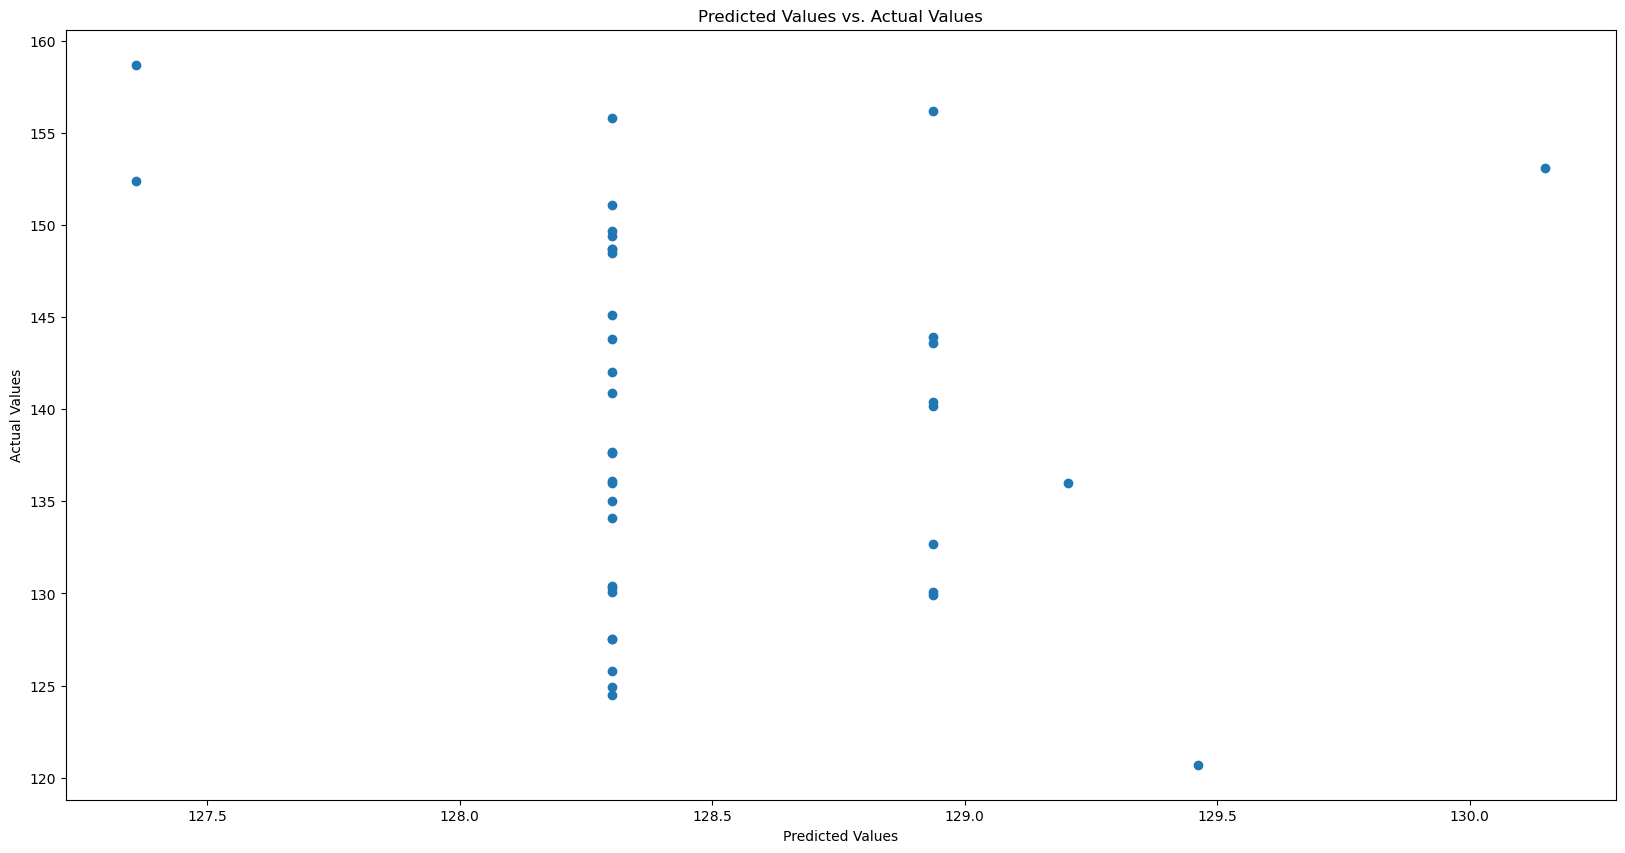

In [116]:
plt.scatter(y_pred, y_test)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted Values vs. Actual Values')
plt.show()

Test Run

In [117]:
input = {
    'Government Agency Debt': 9251.0,
    'Consumer Confident Index': 34.0
}	

In [118]:
input_df = pd.DataFrame(input, index=[0])

In [119]:
input_df

,Government Agency Debt,Consumer Confident Index
0,9251.0,34.0


In [120]:
dt_model.best_estimator_.predict(input_df)

array([142.875])

In [121]:
rf_model.best_estimator_.predict(input_df)

array([134.08284273])

In [122]:
xgb_model.best_estimator_.predict(input_df)

array([133.3947], dtype=float32)